[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]


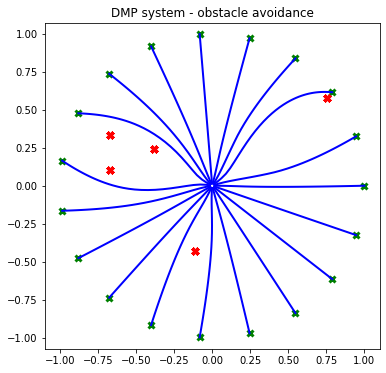

In [1]:
"""
Copyright (C) 2016 Travis DeWolf

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

Modifid: Xiyang Yeh
"""

import numpy as np
import matplotlib.pyplot as plt

import dmp_pkg.dmp_discrete

beta = 20.0 / np.pi
gamma = 100
R_halfpi = np.array(
    [
        [np.cos(np.pi / 2.0), -np.sin(np.pi / 2.0)],
        [np.sin(np.pi / 2.0), np.cos(np.pi / 2.0)],
    ]
)
num_obstacles = 5
obstacles = np.random.random((num_obstacles, 2)) * 2 - 1
obstacles = [[-0.67209116, 0.33417415],
             [-0.66993779, 0.10640643],
             [-0.38101716, 0.23914736],
             [0.75424483, 0.57418764],
             [-0.11455139, -0.42689868]]

def avoid_obstacles(y, dy, goal):
    p = np.zeros(2)

    for obstacle in obstacles:
        # based on (Hoffmann, 2009)

        # if we're moving
        if np.linalg.norm(dy) > 1e-5:

            # get the angle we're heading in
            phi_dy = -np.arctan2(dy[1], dy[0])
            R_dy = np.array(
                [[np.cos(phi_dy), -np.sin(phi_dy)], [np.sin(phi_dy), np.cos(phi_dy)]]
            )
            # calculate vector to object relative to body
            obj_vec = obstacle - y
            # rotate it by the direction we're going
            obj_vec = np.dot(R_dy, obj_vec)
            # calculate the angle of obj relative to the direction we're going
            phi = np.arctan2(obj_vec[1], obj_vec[0])

            dphi = gamma * phi * np.exp(-beta * abs(phi))
            R = np.dot(R_halfpi, np.outer(obstacle - y, dy))
            pval = -np.nan_to_num(np.dot(R, dy) * dphi)

            # check to see if the distance to the obstacle is further than
            # the distance to the target, if it is, ignore the obstacle
            if np.linalg.norm(obj_vec) > np.linalg.norm(goal - y):
                pval = 0

            p += pval
    return p


# test normal run
num_bfs = 10
num_dmps = 2
dmp = dmp_pkg.dmp_discrete.DMPs_discrete(n_dmps=num_dmps, n_bfs=num_bfs, w=np.zeros((num_dmps, num_bfs)))
y_track = np.zeros((dmp.timesteps, dmp.n_dmps))
dy_track = np.zeros((dmp.timesteps, dmp.n_dmps))
ddy_track = np.zeros((dmp.timesteps, dmp.n_dmps))
goals = [[np.cos(theta), np.sin(theta)] for theta in np.linspace(0, 2 * np.pi, 20)[:-1]]
for goal in goals:
    dmp.goal = goal
    dmp.reset()
    for t in range(dmp.timesteps):
        y_track[t], dy_track[t], ddy_track[t] = dmp.step(
            ext_force=avoid_obstacles(dmp.y, dmp.dy, goal)
        )

    plt.figure(1, figsize=(6, 6))
    (plot_goal,) = plt.plot(dmp.goal[0], dmp.goal[1], "gx", mew=3)
    for obstacle in obstacles:
        (plot_obs,) = plt.plot(obstacle[0], obstacle[1], "rx", mew=3)
    (plot_path,) = plt.plot(y_track[:, 0], y_track[:, 1], "b", lw=2)
    plt.title("DMP system - obstacle avoidance")

plt.axis("equal")
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])
plt.show()
